# Kocher's Timing Attack Tutorial

*by Martin Ochoa, zkSecurity*


## Introduction

In 1996, Paul Kocher published [a seminal paper](https://paulkocher.com/doc/TimingAttacks.pdf) demonstrating that the execution time of cryptographic operations could leak information about secret keys. This wasn't a mathematical weakness in the abstract cryptographic algorithms, but rather a side-channel attack that exploited implementation details of real cryptographic systems. 

This tutorial explores timing attacks through three progressive implementations, each revealing different aspects of the challenge. We first start with a simple instruction cost model to illustrate the core dynamics of the attack. We then move on to actual timing measurements on more realistic implementations and show the challenges presented by modern processors and operating systems. Finally, we show some engineering techniques to recover the key signal from noisy measurements. This progression illustrates both the theoretical foundations and practical engineering challenges of side-channel cryptanalysis.

## The Vulnerable Algorithm: Square-and-Multiply

At the heart of RSA encryption and Diffie-Hellman key exchange is modular exponentiation: computing $m^k \ mod \ n$. The standard algorithm is *square-and-multiply*. 

Consider computing $3^{11} \ mod \ 13$. Naively, we can multiply the base 11 times

$$3^{11} = 3 \cdot 3 \cdot 3 \cdot 3 \cdot 3 \cdot 3 \cdot 3 \cdot 3 \cdot 3 \cdot 3 \cdot 3 = 177147 = 9 \ mod \ 13$$

This requires 10 multiplications and grows linearly with the exponent.

Alternatively, we can use the binary representation of 11 = `1011₂`. We can the process bits from least significant to most significant:

$$
\begin{aligned}
\text{Initial:} &\quad result = 1,\; base = 3 \\[6pt]
\text{Bit 0 (LSB): 1} 
   &\quad result = result \times base = 1 \times 3 = 3 \\
   &\quad base = base^2 = 3^2 = 9 \\[6pt]
\text{Bit 1: 1} 
   &\quad result = result \times base = 3 \times 9 = 27 \equiv 1 \pmod{13} \\
   &\quad base = base^2 = 9^2 = 81 \equiv 3 \pmod{13} \\[6pt]
\text{Bit 2: 0} 
   &\quad \text{skip multiplication} \\
   &\quad base = base^2 = 3^2 = 9 \\[6pt]
\text{Bit 3 (MSB): 1} 
   &\quad result = result \times base = 1 \times 9 = 9 \\
   &\quad base = base^2 = 9^2 = 81 \equiv 3 \pmod{13} \\[6pt]
\text{Final result:} &\quad 9
\end{aligned}
$$

This requires only 6 operations (4 squarings + 2 multiplications) vs 10 for naive multiplication.

Now consider a 1024-bit RSA key: Naive ≈ $2^{1024}$ operations vs Square-and-multiply ≈ 1536 operations
Square-and-multiply is exponentially faster, making RSA practical.

In [1]:
import time

def slow_exp(base, exponent, modulus):
    """Naive exponentiation: multiply base by itself exponent times"""
    result = 1
    base = base % modulus
    
    for _ in range(exponent):
        result = (result * base) % modulus
    
    return result

def fast_exp(base, exponent, modulus):
    """LSB-first square-and-multiply exponentiation"""
    if modulus == 1:
        return 0
    
    result = 1
    base = base % modulus
    
    while exponent > 0:
        # Check current bit (LSB first)
        if exponent & 1:  # THE VULNERABLE CONDITIONAL
            result = (result * base) % modulus
        
        # Always square the base for next iteration
        base = (base * base) % modulus
        
        # Shift to next bit
        exponent >>= 1
    
    return result

# Performance comparison with wall-clock timing
def compare_exponentiation_methods():
    """Compare naive vs square-and-multiply with real timing measurements"""
    print("⏱️  Performance Comparison: Naive vs Square-and-Multiply")
    print("=" * 60)
    
    # Test with moderately large numbers to see timing differences
    base = 12345
    exponent = 12345  # Small enough for naive method to complete
    modulus = 2**16 - 1  # 65535
    
    print(f"Computing {base}^{exponent} mod {modulus}")
    print()
    
    # Test naive method
    print("Naive Method:")
    start_time = time.perf_counter()
    result_slow = slow_exp(base, exponent, modulus)
    slow_time = time.perf_counter() - start_time
    print(f"  Result: {result_slow}")
    print(f"  Time: {slow_time:.4f} seconds")
    print(f"  Operations: {exponent} multiplications")
    print()
    
    # Test square-and-multiply
    print("Square-and-Multiply:")
    start_time = time.perf_counter()
    result_fast = fast_exp(base, exponent, modulus)
    fast_time = time.perf_counter() - start_time
    print(f"  Result: {result_fast}")
    print(f"  Time: {fast_time:.4f} seconds") 
    print(f"  Operations: ~{2 * exponent.bit_length()} operations")
    print()
    
    # Verify results match
    assert result_slow == result_fast, "Results don't match!"
    print("Results match - both methods are correct")
    print()
    
    # Performance analysis
    speedup = slow_time / fast_time if fast_time > 0 else float('inf')
    print("📊 Performance Analysis:")
    print(f"  Speedup: {speedup:.1f}x faster")
    print(f"  Time ratio: {slow_time/fast_time:.1f}:1")
    
    

# Run the comparison
compare_exponentiation_methods()

⏱️  Performance Comparison: Naive vs Square-and-Multiply
Computing 12345^12345 mod 65535

Naive Method:
  Result: 55995
  Time: 0.0013 seconds
  Operations: 12345 multiplications

Square-and-Multiply:
  Result: 55995
  Time: 0.0000 seconds
  Operations: ~28 operations

Results match - both methods are correct

📊 Performance Analysis:
  Speedup: 185.1x faster
  Time ratio: 185.1:1


## What about security?

Why is square and multiply interesting from a security perspective? When the current key bit is 1, the algorithm performs an additional modular multiplication operation. This extra computation requires more time, creating a measurable timing difference.

Kocher's insight is: by systematically measuring execution times across many operations and applying statistical analysis techniques, we can distinguish between the faster bit=0 case and the slower bit=1 case, enabling recovery of secret key bits, bit by bit.

The following sections demonstrate this attack through three progressive implementations, each highlighting different technical challenges and solutions.

# Part 1: Kocher's Timing Attack under a perfect signal

At first sight, branching on a secret for exponentiation does not sound that bad. Intuitively this could leak the hamming weight of a key (i.e. the number of 1s in the binary representation of the key). In this section we demonstrate, using a basic implementation based on simple trial subtraction cost modeling, that this apparently small issue can lead to the full leakage of a key.


## Simple Cost Model: Trial Subtraction

To understand how timing leaks can arise, we first need a simplified way to measure the cost of modular arithmetic. Real hardware multiplications followed by modular reduction take variable time depending on the operands. We capture this idea with a trial subtraction cost model: every modular multiplication costs one multiply plus as many subtractions as needed to reduce the product below the modulus. This toy model is simple but already produces the kind of pseudo-random timing variation that Kocher’s attack can exploit.

In [2]:
import numpy as np

def mul_mod_with_cost(a, b, n):
    """
    Multiply with realistic cost modeling via trial subtraction
    Simple trial subtraction creates realistic timing variation
    """
    x = a * b
    k = x // n          # how many subtractions would happen
    x = x - k * n
    return x, 1 + int(k)  # 1 multiply + k "subtractions"

def square_mod_with_cost(a, n):
    """Square with cost counting"""
    return mul_mod_with_cost(a, a, n)

print("Example of low cost of multiplication modulo" ,mul_mod_with_cost(5, 5, 101))
print("Example of higher cost of multiplication modulo", mul_mod_with_cost(5, 70, 101))

Example of low cost of multiplication modulo (25, 1)
Example of higher cost of multiplication modulo (47, 4)


The key feature of this simple subtraction-based cost model is that it naturally introduces variation in the simulated timing. When the product of two numbers is close to the modulus, only a few subtractions are needed to reduce it, resulting in a low cost. In contrast, when the product is much larger than the modulus, many subtractions are required, leading to a higher cost. Because these products depend on both the input message and the evolving intermediate values during exponentiation, the timing variation appears pseudo-random, just as in real modular arithmetic implementations. In other words:

- For small products (x ≈ n) one needs few subtractions → low cost
- For large products(x >> n) one needs many subtractions → high cost  
- The variation is *pseudo-random* based on message and intermediate values

## The Vulnerable Square-and-Multiply Algorithm

Give this simplified multiplication modulo function with our cost estimation, we can instantiate the vulnerable square and multiply function as follows. Note that we introduce both a `fast_exp_with_cost` function returning both the result and the number of operations performed under our cost model.

In [3]:
def fast_exp_with_cost(base, exponent, modulus):
    """
    LSB-first square-and-multiply with operation counting
    Returns: (result, total_cost)
    """
    if modulus == 1:
        return 0, 0
    
    result = 1
    base = base % modulus
    total_cost = 0
    
    while exponent > 0:
        # Check current bit (LSB first)
        if exponent & 1:  # VULNERABLE CONDITIONAL
            result, mul_cost = mul_mod_with_cost(result, base, modulus)
            total_cost += mul_cost
        
        # Always square the base for next iteration
        base, square_cost = square_mod_with_cost(base, modulus)
        total_cost += square_cost
        
        # Shift to next bit
        exponent >>= 1
    
    return result, total_cost



# Test correctness against Python's pow
def test_correctness():
    """Test against Python's pow"""
    print("🔍 CORRECTNESS TEST")
    print("=" * 30)
    
    test_cases = [
        (3, 11, 13),
        (5, 7, 17),
        (123, 456, 789),
    ]
    
    all_correct = True
    for base, exp, mod in test_cases:
        our_result, cost = fast_exp_with_cost(base, exp, mod)
        python_result = pow(base, exp, mod)
        correct = our_result == python_result
        all_correct &= correct
        
        status = "✅" if correct else "❌"
        print(f"{base}^{exp} mod {mod}: our={our_result}, python={python_result} {status} (cost={cost})")
    
    print(f"Overall: {'✅ PASS' if all_correct else '❌ FAIL'}")
    return all_correct

# Verify our implementation
test_correctness()

🔍 CORRECTNESS TEST
3^11 mod 13: our=9, python=9 ✅ (cost=21)
5^7 mod 17: our=10, python=10 ✅ (cost=25)
123^456 mod 789: our=699, python=699 ✅ (cost=2684)
Overall: ✅ PASS


True

## Statistical Foundation: Demonstrating Timing Variability

Before diving into the actual attack, we need to establish the key statistical premise: modular exponentiation timing varies meaningfully across different messages with the same key. This variation is what enables exploitation. Consider the following experiment, where we compute the number of instructions required to perform exponentiation of various random messages under the same key. The variance distinguisher only requires variable-time modular exponentiation and many independent messages. 

Note that for the modulus, we use a (probably) prime modulus for simplicity of exposition. Here we are simulating attacks against Diffie-Hellman implementations over finite fields. In practice, Kocher’s attack also applies to RSA with composite $N = pq$.

STATISTICAL FOUNDATION: Timing Distribution Analysis
Secret key: 53 (0b110101)
Modulus: 3544234957
Analyzing timing distribution across 3000 random messages...

Computing costs for m^k mod n across all messages...
  Progress: 0/3000
  Progress: 100/3000
  Progress: 200/3000
  Progress: 300/3000
  Progress: 400/3000
  Progress: 500/3000
  Progress: 600/3000
  Progress: 700/3000
  Progress: 800/3000
  Progress: 900/3000
  Progress: 1000/3000
  Progress: 1100/3000
  Progress: 1200/3000
  Progress: 1300/3000
  Progress: 1400/3000
  Progress: 1500/3000
  Progress: 1600/3000
  Progress: 1700/3000
  Progress: 1800/3000
  Progress: 1900/3000
  Progress: 2000/3000
  Progress: 2100/3000
  Progress: 2200/3000
  Progress: 2300/3000
  Progress: 2400/3000
  Progress: 2500/3000
  Progress: 2600/3000
  Progress: 2700/3000
  Progress: 2800/3000
  Progress: 2900/3000
  Progress: 3000/3000 — Complete!

 STATISTICAL ANALYSIS:
  Mean cost: 9718752785.5 operations
  Standard deviation: 3575166303.8 operatio

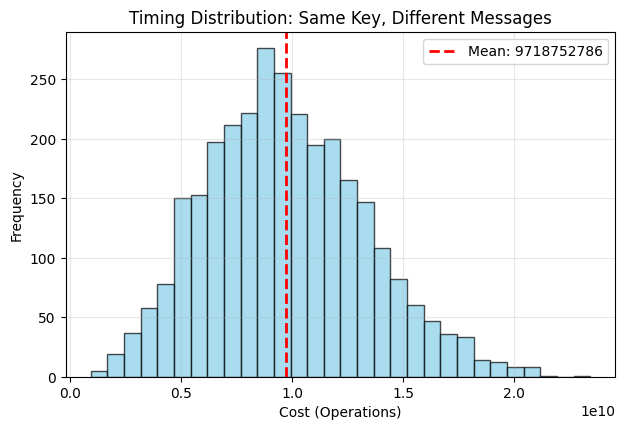

In [4]:
import matplotlib.pyplot as plt
import math
from random import Random

#For reproducibility
rng = Random(12345) 


# Small primes for quick trial division (covers all residues mod their product)
_SMALL_PRIMES = [
    3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47,
    53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107,
    109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167,
    173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229
]

def _decompose(n):
    """Write n-1 as 2^s * d with d odd."""
    d = n - 1
    s = (d & -d).bit_length() - 1  # count trailing zeros
    d >>= s
    return s, d

def _miller_rabin(n, rounds=12):
    """Probabilistic primality test. Error ≤ 4^(-rounds)."""
    if n < 2:
        return False
    # Quick small-prime checks
    for p in _SMALL_PRIMES:
        if n == p:
            return True
        if n % p == 0:
            return False

    s, d = _decompose(n)
    for _ in range(rounds):
        a = rng.randint(2, n - 2) # random in [2, n-2]
        x = pow(a, d, n)
        if x == 1 or x == n - 1:
            continue
        for _ in range(s - 1):
            x = (x * x) % n
            if x == n - 1:
                break
        else:
            return False
    return True

def random_odd(bits):
    """Random odd integer with top bit set (exact bit length)."""
    n = rng.getrandbits(bits)
    n |= (1 << (bits - 1))  # ensure correct size
    n |= 1                  # ensure odd
    return n

def generate_prime(bits=512, rounds=12):
    """
    Generate a random probable prime of 'bits' bits.
    rounds: Miller–Rabin rounds (12 ~ error < 2^-24 per test base; overall negligible).
    """
    assert bits >= 16
    while True:
        candidate = random_odd(bits)
        # quick wheel: reject if divisible by any small prime
        if any(candidate % p == 0 for p in _SMALL_PRIMES):
            continue
        if _miller_rabin(candidate, rounds=rounds):
            return candidate


def demonstrate_timing_distribution():
    """
    Demonstrate that m^k mod n has meaningful timing variation across messages
    This is the statistical foundation that makes Kocher's attack possible
    """
    print("STATISTICAL FOUNDATION: Timing Distribution Analysis")
    print("=" * 60)
    
    # Use a realistic key and modulus
    target_key = 0b110101  # 53 in decimal - our attack target
    #fix a seed for reproducibility

    modulus = generate_prime(32)
    num_messages = 3000
    
    print(f"Secret key: {target_key} ({bin(target_key)})")
    print(f"Modulus: {modulus}")
    print(f"Analyzing timing distribution across {num_messages} random messages...")
    print()
    
    # Generate random messages and measure their timing costs
    messages = [rng.randrange(1, modulus) for _ in range(num_messages)]
    
    print("Computing costs for m^k mod n across all messages...")
    costs = []
    for i, msg in enumerate(messages):
        if i % 100 == 0:
            print(f"  Progress: {i}/{num_messages}")
        
        result, cost = fast_exp_with_cost(msg, target_key, modulus)
        costs.append(cost)
    
    print(f"  Progress: {num_messages}/{num_messages} — Complete!")
    
    costs = np.array(costs)
    
    # Statistical analysis
    mean_cost = np.mean(costs)
    std_cost = np.std(costs)
    min_cost = np.min(costs)
    max_cost = np.max(costs)
    
    print()
    print(" STATISTICAL ANALYSIS:")
    print(f"  Mean cost: {mean_cost:.1f} operations")
    print(f"  Standard deviation: {std_cost:.1f} operations")
    print(f"  Range: {min_cost} to {max_cost} operations")
    print(f"  Coefficient of variation: {(std_cost/mean_cost)*100:.1f}%")
    print()
    
    # Show distribution histogram
    plt.figure(figsize=(12, 8))
    
    # Main histogram
    plt.subplot(2, 2, 1)
    n_bins = 30
    counts, bins, patches = plt.hist(costs, bins=n_bins, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Cost (Operations)')
    plt.ylabel('Frequency')
    plt.title('Timing Distribution: Same Key, Different Messages')
    plt.grid(True, alpha=0.3)
    plt.axvline(mean_cost, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_cost:.0f}')
    plt.legend()
    
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return costs, mean_cost, std_cost

# Demonstrate the statistical foundation

costs, mean_cost, std_cost = demonstrate_timing_distribution()

This demonstration highlights the fundamental statistical structure that underpins Kocher's attack. The cost of modular exponentiation is not constant across messages; instead, it exhibits meaningful variation, sometimes requiring significantly more or fewer operations. When aggregated over many runs, these costs follow a roughly normal distribution, reflecting the central limit theorem at work in the sum of many small operations. 

The reason timing variation can be turned into a full attack is that it provides a real, exploitable signal about the secret key. The normal distribution emerges from the central limit theorem: if each round's timing is an independent random variable, then the sum of many rounds naturally converges to a normal distribution. This independence between rounds is a crucial assumption underlying Kocher's variance distinguisher: it allows us to decompose the total variance into separate contributions from different parts of the computation. As we'll demonstrate next, this independence assumption can be validated empirically, confirming the mathematical foundation for statistical timing attacks.

## Empirical Test: Independence Between Rounds

The variance distinguisher relies on a crucial assumption: that the timing cost of different rounds is statistically independent. As we will discuss in more detail later, this allows us to decompose variance as $\text{Var}[A + B] = \text{Var}[A] + \text{Var}[B]$ when A and B are independent. But is this assumption valid in practice? Let's test it empirically.

First, let us consider a modified version of the `fast_exp_with_cost` function that allows us to compute the cost up of the exponentiation up to a controlled round number as follows.

In [5]:
def fast_exp_controlled_cost(base, exponent, modulus, num_rounds):
    """
    Controlled LSB-first exponentiation - only process first num_rounds
    Returns: total_cost for specified rounds
    """
    if modulus == 1:
        return 0
    
    result = 1
    base = base % modulus
    total_cost = 0
    round_count = 0
    
    while exponent > 0 and round_count < num_rounds:
        # Check current bit (LSB first)
        if exponent & 1:
            result, mul_cost = mul_mod_with_cost(result, base, modulus)
            total_cost += mul_cost
        
        # Always square the base for next iteration
        base, square_cost = square_mod_with_cost(base, modulus)
        total_cost += square_cost
        
        # Shift to next bit
        exponent >>= 1
        round_count += 1
    
    return total_cost

Now we can compare the time taken by a prefix after a given number of rounds (for instance 4), with the time taken by the next round.

In [6]:
def test_round_independence(target_key, modulus, num_messages=1000, prefix_rounds=4):
    """
    Empirically test independence between early rounds and later rounds
    Tests if round costs are statistically independent across messages
    """
    print("EMPIRICAL INDEPENDENCE TEST")
    print("=" * 50)
    print(f"Testing independence between prefix ({prefix_rounds} rounds) and round {prefix_rounds+1}")
    print(f"Test key: {target_key} = {bin(target_key)}")
    print(f"Messages: {num_messages}")
    print(f"Modulus: {modulus}")
    print()
    
    # Generate test messages using the same RNG for reproducibility
    messages = [rng.randrange(1, modulus) for _ in range(num_messages)]
    
    # Measure costs for prefix rounds (e.g., first 4 rounds)
    prefix_costs = []
    # Measure costs for the next single round (round 5)
    next_round_costs = []
    
    print("Collecting timing measurements...")
    for i, msg in enumerate(messages):
        if i % 200 == 0:
            print(f"  Progress: {i}/{num_messages}")
        
        # Cost of first `prefix_rounds` rounds
        prefix_cost = fast_exp_controlled_cost(msg, target_key, modulus, prefix_rounds)
        
        # Cost of just the next round (execute one more round)
        next_round_cost = fast_exp_controlled_cost(msg, target_key, modulus, prefix_rounds+1) - prefix_cost
        
        prefix_costs.append(prefix_cost)
        next_round_costs.append(next_round_cost)
    
    print(f"  Progress: {num_messages}/{num_messages} — Complete!")
    
    # Convert to numpy arrays for analysis
    prefix_costs = np.array(prefix_costs)
    next_round_costs = np.array(next_round_costs)
    
    # Compute correlations
    pearson_corr = np.corrcoef(prefix_costs, next_round_costs)[0, 1]
    
    # Spearman rank correlation (for non-linear relationships)
    def spearman_correlation(x, y):
        """Simple Spearman rank correlation implementation"""
        def rank_data(data):
            """Convert data to ranks (1-based, average for ties)"""
            sorted_data = sorted(enumerate(data), key=lambda x: x[1])
            ranks = [0] * len(data)
            for i, (orig_idx, value) in enumerate(sorted_data):
                ranks[orig_idx] = i + 1
            return ranks
        
        ranks_x = rank_data(x)
        ranks_y = rank_data(y)
        return np.corrcoef(ranks_x, ranks_y)[0, 1]
    
    spearman_corr = spearman_correlation(prefix_costs, next_round_costs)
    
    print()
    print(f"Prefix cost stats: mean={np.mean(prefix_costs):.1f}, std={np.std(prefix_costs):.1f}")
    print(f"Next round cost stats: mean={np.mean(next_round_costs):.1f}, std={np.std(next_round_costs):.1f}")
    print()
    print(f"Pearson correlation: {pearson_corr:.4f}")
    print(f"Spearman correlation: {spearman_corr:.4f}")
    print()
    return pearson_corr, spearman_corr, prefix_costs, next_round_costs

# Run the independence test
target_key = 0b1110101  # 7-bit test key
modulus = generate_prime(32)  # Small modulus for fast testing

pearson, spearman, prefix_data, round_data = test_round_independence(
    target_key, modulus, num_messages=1000, prefix_rounds=4
)

EMPIRICAL INDEPENDENCE TEST
Testing independence between prefix (4 rounds) and round 5
Test key: 117 = 0b1110101
Messages: 1000
Modulus: 2487266239

  Progress: 0/1000
  Progress: 200/1000
  Progress: 400/1000
  Progress: 600/1000
  Progress: 800/1000
  Progress: 1000/1000 — Complete!

Prefix cost stats: mean=3850532455.8, std=1901856207.9
Next round cost stats: mean=1455461780.0, std=1173936808.1

Pearson correlation: -0.0335
Spearman correlation: -0.0338



As we can see the correlation factor is very small (less than 0.1), which confirms the intuition that the time for round $i+1$ is essentially a 
random variable independent from the time up to the prefix consisting of the first $i$ rounds.

## Kocher's Variance Distinguisher


Now let us discuss the consequences of this independence between rounds in more detail. Recall the definition of variance:  
$$
\mathrm{Var}[X] = \frac{1}{n}\sum_{j=1}^n \big(X_j - \mu_X\big)^2,
$$
where $\mu_X = \frac{1}{n}\sum_{j=1}^n X_j$ is the mean of $X$.

If $A$ and $B$ are independent random variables, then for either $A+B$ or $A-B$ we have  
$$
\begin{aligned}
\mathrm{Var}[A \pm B] 
&= \frac{1}{n}\sum_{j=1}^n \Big( (A_j \pm B_j) - (\mu_A \pm \mu_B)\Big)^2 \\
&= \frac{1}{n}\sum_{j=1}^n (A_j - \mu_A)^2 
  + \frac{1}{n}\sum_{j=1}^n (\pm B_j - \pm \mu_B)^2 
  + \frac{2}{n}\sum_{j=1}^n (A_j - \mu_A)(\pm B_j - \pm \mu_B).
\end{aligned}
$$

Because $(\pm B_j - \pm \mu_B)^2 = (B_j - \mu_B)^2$, and independence ensures the cross-term vanishes, this simplifies to  
$$
\mathrm{Var}[A \pm B] = \mathrm{Var}[A] + \mathrm{Var}[B].
$$

By induction, the same holds with more terms:  
$$
\mathrm{Var}[A \pm B \pm C] = \mathrm{Var}[A] + \mathrm{Var}[B] + \mathrm{Var}[C].
$$

This property underlies Kocher’s distinguisher: if the hypothesis is correct, the error reduces to the variance of the suffix; if wrong, an extra variance term appears.

For each message $m$, the total cost of exponentiation up to round $i$ can be written as  
$$
T_m = \text{prefix}_m^{(i)} + \text{suffix}_m^{(i)},
$$
where $\text{prefix}_m^{(i)}$ is the cost of the first $i$ rounds and $\text{suffix}_m^{(i)}$ is the remaining cost.

If we subtract the correct hypothesis for the prefix, the residual equals just the suffix:  
$$
T_m - \text{prefix}_m^{(i,\text{correct})} = \text{suffix}_m^{(i)}.
$$
In this case the variance is simply  
$$
\mathrm{Var}[T - \text{prefix}^{(i,\text{correct})}] = \mathrm{Var}[\text{suffix}^{(i)}].
$$

If we subtract an incorrect hypothesis, the residual includes an additional mismatch term:  
$$
T_m - \text{prefix}_m^{(i,\text{wrong})} = \text{suffix}_m^{(i)} \pm \Delta_m^{(i)}.
$$
Here $\Delta_m^{(i)}$ represents the error from the wrong hypothesis. Crucially, this error is independently and randomly distributed across messages, so it contributes extra variance. The sign does not matter, since variance depends only on squared deviations. Thus we obtain  
$$
\mathrm{Var}[T - \text{prefix}^{(i,\text{wrong})}] = \mathrm{Var}[\text{suffix}^{(i)}] + \mathrm{Var}[\Delta^{(i)}].
$$

Therefore, if the variance of the error is not trivial, we expect:

$$
\mathrm{Var}[T - \text{prefix}^{(i,\text{correct})}] < \mathrm{Var}[T - \text{prefix}^{(i,\text{wrong})}].
$$

The independence of the mismatch term is key: it ensures that wrong hypotheses systematically inflate the variance, which is exactly the statistical signal exploited by Kocher’s distinguisher.


To make the attack concrete, we start with the second-least-significant bit of the exponent. This known LSB anchors the attack, so the distinguisher’s task is simply to decide whether the next bit (bit 1) is 0 or 1 by comparing the variances of the two hypotheses. In real RSA exponents the least significant bit is always 1, since the private key must be odd. This makes it natural to assume the first round is known in advance. For simplicity of exposition, we adopt the same assumption here. The impact on the model is minimal, since the very first multiplication round does not introduce much variability anyway (multiplying by 1). This lets us focus attention on the second bit, where the distinguisher begins to reveal useful structure.



We are now ready to show the code to use our variance distinguisher against the 2nd bit of an unknown key (assuming the first bit is known).

In [7]:
def attack_second_lsb_bit(target_key, num_messages=100, modulus=None):
    """
    Attack second LSB bit using Kocher's variance distinguisher
    Assume first LSB bit is known (odd)
    """
    print("SECOND LSB BIT ATTACK")
    print("=" * 40)
    
    # Use provided modulus or generate random prime
    if modulus is None:
        modulus = generate_prime(32)
    print(f"Target: {target_key} = {bin(target_key)}")
    print(f"Modulus: {modulus}")
    
    # Assume first bit (LSB) is always 1 (odd number)
    # Attack starts from second LSB bit (bit position 1)
    second_lsb = (target_key >> 1) & 1
    
    print(f"First LSB (bit 0): 1 (assumed known)")
    print(f"Second LSB (bit 1): {second_lsb} (target to recover)")
    
    # Create hypotheses: longer keys with MSB=1 and many zeros to ensure substantial work
    # Use format: MSB=1 + zeros + second_LSB + first_LSB=1
    key_length = max(16, target_key.bit_length())  # Ensure substantial length
    base_key = (1 << (key_length - 1)) | 1  # MSB=1, LSB=1: 100...0001
    
    h0_key = base_key  # Second LSB = 0: 100...0001
    h1_key = base_key | 2  # Second LSB = 1: 100...0011
    
    print(f"H0: {h0_key} = {bin(h0_key)} (2nd LSB = 0)")
    print(f"H1: {h1_key} = {bin(h1_key)} (2nd LSB = 1)")
    
    # Generate random messages


    messages = [rng.randrange(1, modulus) for _ in range(num_messages)]
    
    # STEP 1: Collect baseline measurements (full exponentiation)
    print(f"Collecting {num_messages} baseline measurements...")
    baseline_costs = []
    for msg in messages:
        result, cost = fast_exp_with_cost(msg, target_key, modulus)
        baseline_costs.append(cost)
    
    baseline_costs = np.array(baseline_costs)
    print(f"Baseline: mean={np.mean(baseline_costs):.1f}, std={np.std(baseline_costs):.1f}")
    
    # STEP 2: Collect predictions (2 rounds: LSB + 2nd LSB)
    print("🔍 Collecting hypothesis predictions...")
    h0_predictions = []
    h1_predictions = []
    
    rounds_to_process = 2  # We want to simulate cost of hypothesis up to the 2nd round
    
    for msg in messages:
        h0_cost = fast_exp_controlled_cost(msg, h0_key, modulus, rounds_to_process)
        h1_cost = fast_exp_controlled_cost(msg, h1_key, modulus, rounds_to_process)
        h0_predictions.append(h0_cost)
        h1_predictions.append(h1_cost)
    
    h0_predictions = np.array(h0_predictions)
    h1_predictions = np.array(h1_predictions)
    
    # STEP 3: Kocher's variance distinguisher
    print("⚖️  Applying variance distinguisher...")
    
    # Calculate prediction errors: baseline - prediction
    h0_errors = baseline_costs - h0_predictions
    h1_errors = baseline_costs - h1_predictions
    
    # Compute variances of prediction errors
    h0_variance = np.var(h0_errors)
    h1_variance = np.var(h1_errors)
    
    # Decision: lower variance wins (better prediction)
    if h0_variance < h1_variance:
        predicted_bit = 0
        winner = "H0"
    else:
        predicted_bit = 1
        winner = "H1"
    
    attack_success = predicted_bit == second_lsb
    
    # Results
    print("RESULTS")
    print("-" * 25)
    print(f"H0 error variance: {h0_variance:.2e}")
    print(f"H1 error variance: {h1_variance:.2e}")
    print(f"Winner: {winner}")
    print(f"Predicted 2nd LSB: {predicted_bit}")
    print(f"Actual 2nd LSB: {second_lsb}")
    print(f"Success: {'✅' if attack_success else '❌'}")
    
    return attack_success




target_key = 0b110101  # 53 in decimal
#fix a seed for reproducibility

modulus = generate_prime(32)

# Attack second LSB bit only
print( "=" * 60)
success_2nd = attack_second_lsb_bit(target_key, num_messages=500, modulus=modulus)
print(f"Second bit attack when second bit is 0: {'✅ SUCCESS' if success_2nd else '❌ FAILED'} ")

target_key = 0b110111  # 55 in decimal

# Attack second LSB bit only
print( "=" * 60)
success_2nd = attack_second_lsb_bit(target_key, num_messages=500, modulus=modulus)
print(f"Second bit attack when second bit is 1: {'✅ SUCCESS' if success_2nd else '❌ FAILED'} ")

SECOND LSB BIT ATTACK
Target: 53 = 0b110101
Modulus: 3841597009
First LSB (bit 0): 1 (assumed known)
Second LSB (bit 1): 0 (target to recover)
H0: 32769 = 0b1000000000000001 (2nd LSB = 0)
H1: 32771 = 0b1000000000000011 (2nd LSB = 1)
Baseline: mean=10667047340.9, std=4008150358.7
🔍 Collecting hypothesis predictions...
⚖️  Applying variance distinguisher...
RESULTS
-------------------------
H0 error variance: 1.17e+19
H1 error variance: 1.19e+19
Winner: H0
Predicted 2nd LSB: 0
Actual 2nd LSB: 0
Success: ✅
Second bit attack when second bit is 0: ✅ SUCCESS 
SECOND LSB BIT ATTACK
Target: 55 = 0b110111
Modulus: 3841597009
First LSB (bit 0): 1 (assumed known)
Second LSB (bit 1): 1 (target to recover)
H0: 32769 = 0b1000000000000001 (2nd LSB = 0)
H1: 32771 = 0b1000000000000011 (2nd LSB = 1)
Baseline: mean=11404962632.2, std=4097084638.8
🔍 Collecting hypothesis predictions...
⚖️  Applying variance distinguisher...
RESULTS
-------------------------
H0 error variance: 1.16e+19
H1 error variance: 1

As you can see, we can successfully recover the second bit of the key by observing the (ideal) cost observations for multiple 
messages and implementing a variance-based distinguisher. In the following we generalize this attack to recover the full key, which essentially
is the same attack by iteratively updating the prefix and the position we want to attack.

## Full Progressive Key Recovery

Now we implement the complete attack that recovers all bits systematically:

In [8]:
def full_lsb_key_recovery(target_key, num_messages=1000, modulus=None):
    """
    Full progressive LSB key recovery attack
    Assumes first bit (LSB) is 1
    """
    print("🔓 FULL LSB KEY RECOVERY ATTACK")
    print("=" * 50)
    
    target_key_bin = bin(target_key)
    bit_length = target_key.bit_length()
    
    print(f"Target key: {target_key} = {target_key_bin}")
    print(f"Key length: {bit_length} bits")
    print(f"Assuming bit 0 (LSB) = 1 ")
    print(f"Recovering bits 1 to {bit_length-1} (LSB+1 to MSB)...")
    print()
    
    # Use provided modulus or generate random prime
    if modulus is None:
        modulus = generate_prime(32)
    print(f"Using modulus: {modulus}")
    
    # Generate random messages once
    #fix a seed for reproducibility

    messages = [rng.randrange(1, modulus) for _ in range(num_messages)]
    
    # Collect baseline measurements (full exponentiation with true key)
    print(f"📊 Collecting {num_messages} baseline measurements...")
    baseline_costs = []
    for msg in messages:
        result, cost = fast_exp_with_cost(msg, target_key, modulus)
        baseline_costs.append(cost)
    baseline_costs = np.array(baseline_costs)
    print(f"Baseline: mean={np.mean(baseline_costs):.0f}, std={np.std(baseline_costs):.0f}")
    print()
    
    # Progressive key recovery - start with LSB=1 assumed
    recovered_key = 1  # Start with LSB=1 already known
    recovery_results = []
    
    print("🎯 Progressive Bit Recovery:")
    print("-" * 40)
    print(f"Bit 0 (LSB): assumed 1")
    print(f"Recovered so far: 1 = 0b1")
    print()
    
    # Attack bits 1 through bit_length-1
    for bit_pos in range(1, bit_length):
        actual_bit = (target_key >> bit_pos) & 1
        
        print(f"Attacking bit {bit_pos} (LSB+{bit_pos})")
        print(f"  Actual bit: {actual_bit}")
        
        # Create expanded hypothesis keys
        key_length = max(16, bit_length)
        base_pattern = (1 << (key_length - 1)) | recovered_key  # MSB=1 + recovered so far
        
        h0_key = base_pattern  # Current bit = 0
        h1_key = base_pattern | (1 << bit_pos)  # Current bit = 1
        
        print(f"  H0: {h0_key} = {bin(h0_key)} (bit {bit_pos} = 0)")
        print(f"  H1: {h1_key} = {bin(h1_key)} (bit {bit_pos} = 1)")
        
        # Collect predictions with enough rounds to capture differential work
        rounds_to_process = bit_pos + 1  # Process enough rounds
        h0_predictions = []
        h1_predictions = []
        
        for msg in messages:
            h0_cost = fast_exp_controlled_cost(msg, h0_key, modulus, rounds_to_process)
            h1_cost = fast_exp_controlled_cost(msg, h1_key, modulus, rounds_to_process)
            h0_predictions.append(h0_cost)
            h1_predictions.append(h1_cost)
        
        h0_predictions = np.array(h0_predictions)
        h1_predictions = np.array(h1_predictions)
        
        # Variance distinguisher
        h0_errors = baseline_costs - h0_predictions
        h1_errors = baseline_costs - h1_predictions
        h0_variance = np.var(h0_errors)
        h1_variance = np.var(h1_errors)
        
        if h0_variance < h1_variance:
            predicted_bit = 0
            winner = "H0"
        else:
            predicted_bit = 1
            winner = "H1"
        
        attack_success = predicted_bit == actual_bit
        
        # Update recovered key
        if predicted_bit == 1:
            recovered_key |= (1 << bit_pos)
        
        # Store results
        recovery_results.append({
            'bit_position': bit_pos,
            'actual_bit': actual_bit,
            'predicted_bit': predicted_bit,
            'success': attack_success,
            'h0_variance': h0_variance,
            'h1_variance': h1_variance
        })
        
        # Show results
        status = "✅" if attack_success else "❌"
        print(f"  H0 error variance: {h0_variance:.2e}")
        print(f"  H1 error variance: {h1_variance:.2e}")
        print(f"  Winner: {winner} ")
        print(f"  Predicted: {predicted_bit} {status}")
        print(f"  Recovered so far: {recovered_key} = {bin(recovered_key)}")
        print()
    
    # Final analysis
    total_bits = len(recovery_results)
    successful_bits = sum(1 for r in recovery_results if r['success'])
    accuracy = (successful_bits + 1) / bit_length  # +1 for assumed LSB bit
    
    print("🎯 FINAL RECOVERY ANALYSIS")
    print("=" * 40)
    print(f"Target key:    {target_key:>3} = {bin(target_key)}")
    print(f"Recovered key: {recovered_key:>3} = {bin(recovered_key)}")
    print(f"Accuracy: {successful_bits + 1}/{bit_length} = {accuracy:.1%} (includes assumed LSB)")
    print(f"Complete recovery: {'✅' if recovered_key == target_key else '❌'}")
    print()
    
    # Bit-by-bit breakdown
    print("📊 BIT-BY-BIT BREAKDOWN")
    print("-" * 70)
    print(f"{'Bit':<4} {'Actual':<6} {'Pred':<6} {'Success':<8} {'H0 Variance':<12} {'H1 Variance':<12} {'Conf':<6}")
    print("-" * 70)
    print(f"0    1      1      ✅        N/A          N/A          N/A   (assumed)")
    
    for result in recovery_results:
        bit_pos = result['bit_position']
        actual = result['actual_bit']
        predicted = result['predicted_bit']
        success = "✅" if result['success'] else "❌"
        h0_var = result['h0_variance']
        h1_var = result['h1_variance']
        
        print(f"{bit_pos:<4} {actual:<6} {predicted:<6} {success:<8} {h0_var:<12.2e} {h1_var:<12.2e} ")
    
    
    return recovered_key == target_key, accuracy, recovery_results

Let's run the complete attack demonstration:

In [9]:
# Full key recovery attack  
print("=" * 60)
complete_success, accuracy, results = full_lsb_key_recovery(target_key, num_messages=500, modulus=modulus)

print(f"FINAL RESULT:")
print(f"Second LSB attack: {'SUCCEEDED' if success_2nd else 'FAILED'} ")
print(f"Complete key recovery: {'SUCCEEDED' if complete_success else 'FAILED'}")
print(f"Overall accuracy: {accuracy:.1%}")

🔓 FULL LSB KEY RECOVERY ATTACK
Target key: 55 = 0b110111
Key length: 6 bits
Assuming bit 0 (LSB) = 1 
Recovering bits 1 to 5 (LSB+1 to MSB)...

Using modulus: 3841597009
📊 Collecting 500 baseline measurements...
Baseline: mean=11395133053, std=4208051951

🎯 Progressive Bit Recovery:
----------------------------------------
Bit 0 (LSB): assumed 1
Recovered so far: 1 = 0b1

Attacking bit 1 (LSB+1)
  Actual bit: 1
  H0: 32769 = 0b1000000000000001 (bit 1 = 0)
  H1: 32771 = 0b1000000000000011 (bit 1 = 1)
  H0 error variance: 1.10e+19
  H1 error variance: 9.70e+18
  Winner: H1 
  Predicted: 1 ✅
  Recovered so far: 3 = 0b11

Attacking bit 2 (LSB+2)
  Actual bit: 1
  H0: 32771 = 0b1000000000000011 (bit 2 = 0)
  H1: 32775 = 0b1000000000000111 (bit 2 = 1)
  H0 error variance: 7.61e+18
  H1 error variance: 7.24e+18
  Winner: H1 
  Predicted: 1 ✅
  Recovered so far: 7 = 0b111

Attacking bit 3 (LSB+3)
  Actual bit: 0
  H0: 32775 = 0b1000000000000111 (bit 3 = 0)
  H1: 32783 = 0b1000000000001111 (bit

We have successfully recovered all 6 bits for this key! Note that interestingly the variance for the last correct hypothesis was exactly 0, which is expected given that our ideal signal has no noise and we have correctly guessed all previous rounds. 

Can we directly apply this attack using a more realistic wall clock measurement, perhaps for bigger moduli and keys?

# Part 2: Wall-Clock Timing Challenges

This section demonstrates the practical challenges of timing attacks using realistic wall-clock measurements. Unlike the precise operation counting from Part 1, wall-clock timing introduces system noise, scheduling variations, and measurement artifacts that significantly complicate the attack.

The goal is to understand why naive implementations of timing attacks often fail in real-world conditions, motivating the need for more sophisticated measurement techniques.

## Part 2 Infrastructure: Wall-Clock Timing

Unlike Part 1's perfect operation counting, Part 2 uses realistic wall-clock timing with all its inherent noise and variability. To this end, we define the necessary functions as we did in Part 1. To measure time, we take into account an amplification factor, with the hope of minimizing noise and improving the signal quality. We can reuse the same `fast_exp` we had in the introduction, and introduce the controlled version that allows us to 
select a round number to test our distinguishing hypothesis.

In [10]:
import time
import numpy as np
import matplotlib.pyplot as plt


def fast_exp_controlled(base, exponent, modulus, rounds):
    """
    Controlled version that runs exactly 'rounds' iterations.
    Used for hypothesis testing in Kocher's attack.
    """
    result = 1
    base = base % modulus
    round_count = 0
    
    while exponent > 0 and round_count < rounds:
        if exponent & 1:
            result = (result * base) % modulus
        
        base = (base * base) % modulus
        exponent >>= 1
        round_count += 1
    
    return result

def measure_timing(message, exponent, modulus, rounds=None, amplification=100):
    """
    Measure wall-clock timing for cryptographic operations.
    
    Args:
        message: Random message to encrypt
        exponent: Secret exponent (or hypothesis)
        modulus: RSA/DH modulus
        rounds: Number of controlled rounds (None = full exponentiation)
        amplification: Repetition factor for averaging (INTENTIONALLY LOW)
    
    Returns:
        Average execution time in microseconds
    """
    # Wrap amplification once to avoid call overhead jitter
    start = time.perf_counter_ns()
    
    for _ in range(amplification):
        if rounds is None:
            # Full exponentiation for baseline
            fast_exp(message, exponent, modulus)
        else:
            # Controlled exponentiation for hypothesis testing
            fast_exp_controlled(message, exponent, modulus, rounds)
    
    end = time.perf_counter_ns()
    
    # Return average time per operation in microseconds
    return (end - start) / amplification / 1000

print(" Wall-clock timing infrastructure ready!")

 Wall-clock timing infrastructure ready!


## Validating the Normal Distribution

Before examining the noise challenges, let's first confirm that wall-clock timing of modular exponentiation follows the normal distribution predicted by our theoretical analysis in Part 1. This validation bridges the gap between our cost model and real-world measurements. To highlight the 
shape of the distribution we are going to filter potential outliers in our experiment. To reduce the impact of expected noise, we will amplify measurements 100x.

TIMING DISTRIBUTION ANALYSIS
Validating normal distribution of wall-clock timing...

  Progress: 0/2000
  Progress: 50/2000
  Progress: 100/2000
  Progress: 150/2000
  Progress: 200/2000
  Progress: 250/2000
  Progress: 300/2000
  Progress: 350/2000
  Progress: 400/2000
  Progress: 450/2000
  Progress: 500/2000
  Progress: 550/2000
  Progress: 600/2000
  Progress: 650/2000
  Progress: 700/2000
  Progress: 750/2000
  Progress: 800/2000
  Progress: 850/2000
  Progress: 900/2000
  Progress: 950/2000
  Progress: 1000/2000
  Progress: 1050/2000
  Progress: 1100/2000
  Progress: 1150/2000
  Progress: 1200/2000
  Progress: 1250/2000
  Progress: 1300/2000
  Progress: 1350/2000
  Progress: 1400/2000
  Progress: 1450/2000
  Progress: 1500/2000
  Progress: 1550/2000
  Progress: 1600/2000
  Progress: 1650/2000
  Progress: 1700/2000
  Progress: 1750/2000
  Progress: 1800/2000
  Progress: 1850/2000
  Progress: 1900/2000
  Progress: 1950/2000
  Progress: 2000/2000 — Complete!

📈 DISTRIBUTION ANALYSIS

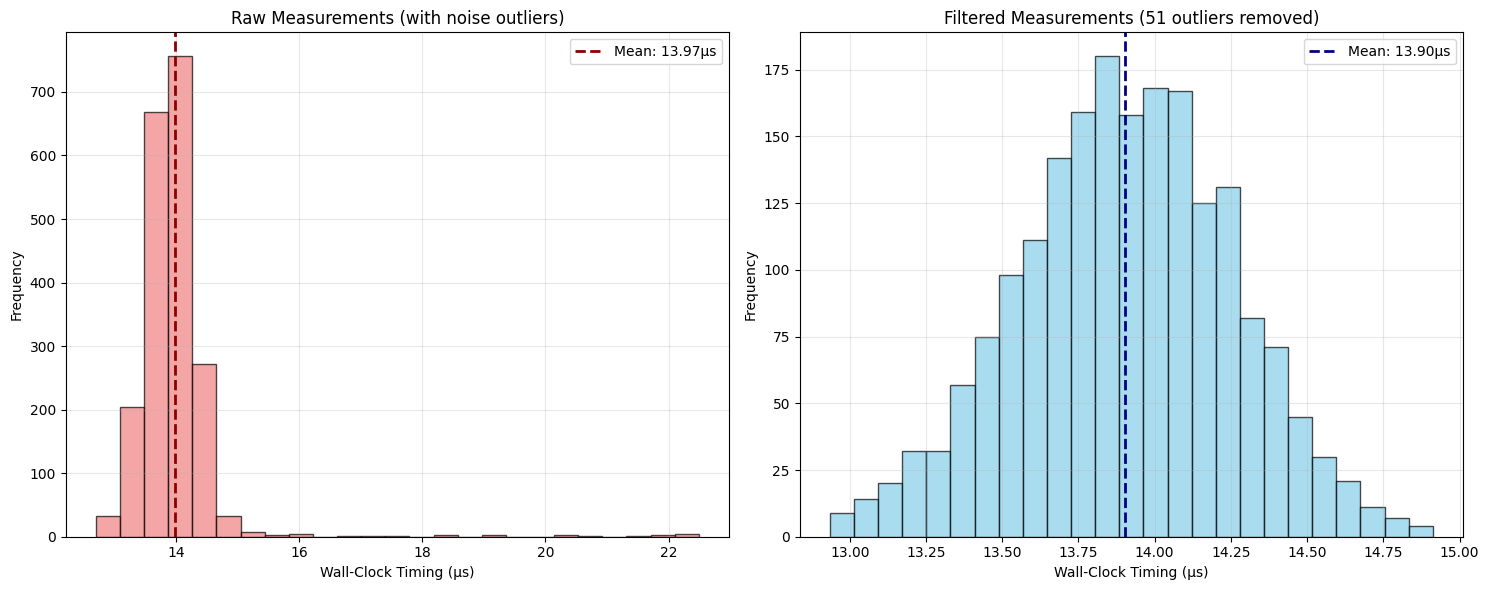

In [24]:
def demonstrate_timing_normality():
    """
    Show that wall-clock timing of m^k follows normal distribution
    Validates the theoretical foundation from Part 1
    """
    print("TIMING DISTRIBUTION ANALYSIS")
    print("=" * 50)
    print("Validating normal distribution of wall-clock timing...")
    print()
    
    # Use consistent parameters
    modulus = generate_prime(512)
    test_key = 0b1101011  # 7-bit key from Part 1
    
    # Collect timing measurements
    timings = []
    num_measurements = 2000
    
    print("Collecting wall-clock measurements...")
    for i in range(num_measurements):
        if i % 50 == 0:
            print(f"  Progress: {i}/{num_measurements}")
        
        # Generate random message
        message = rng.randrange(1, modulus)
        
        # Measure full exponentiation timing
        timing = measure_timing(message, test_key, modulus, rounds=None, amplification=100)
        timings.append(timing)
    
    print(f"  Progress: {num_measurements}/{num_measurements} — Complete!")
    
    # Statistical analysis
    timings = np.array(timings)
    mean_time = np.mean(timings)
    std_time = np.std(timings)
    
    print()
    print("📈 DISTRIBUTION ANALYSIS:")
    print(f"Mean timing: {mean_time:.2f}μs")
    print(f"Standard deviation: {std_time:.2f}μs")
    print(f"Coefficient of variation: {(std_time/mean_time)*100:.1f}%")
    print()
    
    # Show distribution histogram - before and after outlier filtering
    import matplotlib.pyplot as plt
    
    # Filter outliers using IQR method
    def filter_outliers(data, factor=1.5):
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1
        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr
        return data[(data >= lower_bound) & (data <= upper_bound)]
    
    filtered_timings = filter_outliers(timings)
    num_outliers = len(timings) - len(filtered_timings)
    
    # Create side-by-side plots
    plt.figure(figsize=(15, 6))
    
    # Raw data with outliers
    plt.subplot(1, 2, 1)
    n_bins = 25
    counts, bins, patches = plt.hist(timings, bins=n_bins, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.xlabel('Wall-Clock Timing (μs)')
    plt.ylabel('Frequency')
    plt.title('Raw Measurements (with noise outliers)')
    plt.grid(True, alpha=0.3)
    plt.axvline(mean_time, color='darkred', linestyle='--', linewidth=2, label=f'Mean: {mean_time:.2f}μs')
    plt.legend()
    
    # Filtered data without outliers
    plt.subplot(1, 2, 2)
    filtered_mean = np.mean(filtered_timings)
    counts_clean, bins_clean, patches_clean = plt.hist(filtered_timings, bins=n_bins, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Wall-Clock Timing (μs)')
    plt.ylabel('Frequency')
    plt.title(f'Filtered Measurements ({num_outliers} outliers removed)')
    plt.grid(True, alpha=0.3)
    plt.axvline(filtered_mean, color='navy', linestyle='--', linewidth=2, label=f'Mean: {filtered_mean:.2f}μs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    
    return timings, mean_time, std_time

# Run the normality demonstration
wall_clock_timings, mean_timing, std_timing = demonstrate_timing_normality()

This confirms that our theoretical predictions hold: wall-clock timing exhibits the expected normal distribution, validating the statistical foundation for timing attacks. However, as we'll see next, the practical challenge lies not in the distribution shape, but in the signal-to-noise ratio.

## Demonstrating the Noise Problem

Before we attempt to attack this implementation using timing, let us try to understand the issue. We expect the signal to be noisy
in a modern operating system using Python because of various factors, including random scheduling, caching and other optimizations.

The intuition behind the signal-to-noise calculation is simple: if the extra multiplication (bit=1) consistently takes longer than the no-multiplication case (bit=0), then the signal is the average difference between the two means. But since each measurement is perturbed by operating system scheduling, cache effects, and other runtime noise, the noise is captured by the variability (standard deviation) within each set of measurements. If the signal is small compared to the noise, the timing difference is effectively drowned out; if it is large, an attacker could, in principle, detect the hidden bit.

In [25]:
def demonstrate_noise_problem():
    """
    Show the signal-to-noise ratio problem that makes naive timing attacks fail.
    """
    print(" Demonstrating the noise problem:")
    print("=" * 50)
    
    # Use realistic parameters to show the noise problem

    modulus = generate_prime(512)
    test_message = rng.randrange(1, modulus)
    
    # Measure timing for bit=0 vs bit=1 cases
    times_0 = []
    times_1 = []
    
    for _ in range(10):
        time_0 = measure_timing(test_message, 8, modulus, rounds=1, amplification=100)  # bit=0 case
        time_1 = measure_timing(test_message, 9, modulus, rounds=1, amplification=100)  # bit=1 case
        times_0.append(time_0)
        times_1.append(time_1)
    
    mean_0, std_0 = np.mean(times_0), np.std(times_0)
    mean_1, std_1 = np.mean(times_1), np.std(times_1)
    signal = abs(mean_1 - mean_0)
    noise = max(std_0, std_1)
    
    print(f"Example timing measurements:")
    print(f"  Bit=0 case: {mean_0:.3f}μs ± {std_0:.3f}μs")
    print(f"  Bit=1 case: {mean_1:.3f}μs ± {std_1:.3f}μs")
    print(f"  Signal (difference): {signal:.3f}μs")
    print(f"  Noise (std dev): {noise:.3f}μs")
    print(f"  Signal-to-noise ratio: {signal/noise:.2f}")
    print()
    
demonstrate_noise_problem()

 Demonstrating the noise problem:
Example timing measurements:
  Bit=0 case: 1.253μs ± 0.030μs
  Bit=1 case: 1.305μs ± 0.043μs
  Signal (difference): 0.052μs
  Noise (std dev): 0.043μs
  Signal-to-noise ratio: 1.22



These experiments illustrate why naive timing attacks fail under realistic conditions. The timing difference introduced by an extra multiplication in the $bit=1$ case is small compared to the variability in wall-clock measurements. In practice, the random noise introduced by the interpreter, operating system scheduling, caching, and hardware effects is often several times larger than the signal itself. As a result, the signal-to-noise ratio is low, and the useful information is effectively drowned out by randomness. This means that without additional techniques—such as amplification, filtering, or more precise timing sources—an attacker cannot reliably distinguish between key bits.

Even when amplification is applied, the variance across runs remains dominated by noise. Repetition should in theory average out randomness, but in practice the system-level variability persists, making the extra cost of a single multiply indistinguishable. This highlights the fundamental challenge of exploiting wall-clock timing directly: the leakage is present in principle, but obscured in practice by measurement noise.

## Naive Kocher Attack with Wall-Clock Timing

Now let us try to mount a bit recovery attack as we did in Part 1 with this setup, to test if we can build a reliable distinguisher or not.

In [13]:
def naive_kocher_attack(target_key, modulus, num_messages=500):
    """
    Naive implementation of Kocher's timing attack with wall-clock timing.
    
    This version demonstrates why naive approaches fail:
    - System noise overwhelms timing signals
    - Small amplification can't overcome statistical noise
    - Wall-clock timing includes scheduling, cache misses, interrupts
    - Large modulus makes timing differences relatively smaller
    
     This attack is EXPECTED to fail or be unreliable!
    """
    print(f"  Reality Check - Naive Wall-Clock Timing Attack")
    print("=" * 60)
    print(f"Target key: {target_key} (binary: {bin(target_key)})")
    print(f"Modulus: {modulus} ({modulus.bit_length()} bits)")
    print(f"Timing source: Wall-clock (time.perf_counter())")
    print(f"Messages: {num_messages}")
    print(f"Amplification: (100 iterations per measurement")
    print()
    
    
    # Step 1: Generate random test messages
    print("Step 1: Generating random messages...")
    
    messages = [rng.randrange(1, modulus) for _ in range(num_messages)]
    print(f"Generated {len(messages)} random messages")
    print()
    
    # Step 2: Collect baseline measurements  
    print("Step 2: Collecting baseline measurements (full exponentiation)...")
    print(" Warning: This uses wall-clock timing - expect noise!")
    
    baseline_measurements = []
    for i, msg in enumerate(messages):
        if i % 50 == 0:
            print(f"  Progress: {i}/{num_messages}")
        timing = measure_timing(msg, target_key, modulus, rounds=None, amplification=100)
        baseline_measurements.append(timing)
    print(f"  Progress: {num_messages}/{num_messages} — Complete!")
    
    baseline_measurements = np.array(baseline_measurements)
    mean_time = np.mean(baseline_measurements)
    std_time = np.std(baseline_measurements)
    print(f"Baseline complete. Mean: {mean_time:.3f}μs, Std: {std_time:.3f}μs")
    print(f"Coefficient of variation: {(std_time/mean_time)*100:.1f}% (high = noisy!)")
    print()
    
    # Step 3: Attack each bit position
    num_bits_key = target_key.bit_length()
    bits_to_recover = min(5, num_bits_key - 1)  # Only try first 5 bits
    
    print(f"Step 3: Attempting to recover {bits_to_recover} bits...")
    print(" Warning: With high noise, variance distinguisher becomes unreliable")
    print()
    
    # Use fewer messages for attack to reduce computation time (still more than Part)
    attack_messages = messages[:min(len(messages), 200)]  
    attack_baseline = baseline_measurements[:len(attack_messages)]
    
    # Start with LSB=1 assumed
    recovered_key = 1  # LSB known to be 1
    correct_bits = 1   # Count the assumed LSB as correct
    
    print("🔑 Exponent Assumption:")
    print(f"  Bit 0 (LSB): 1 (assumed known and odd)")
    print(f"  Starting attack from bit 1 (second LSB)...")
    print()
    
    for bit_pos in range(1, bits_to_recover + 1):  # Start from bit 1
        print(f"--- Attempting bit {bit_pos} (LSB+{bit_pos}) ---")
        
        # Create expanded hypothesis keys with MSB=1 for substantial work
        key_length = max(16, num_bits_key)
        base_pattern = (1 << (key_length - 1)) | recovered_key  # MSB=1 + recovered so far
        
        hypothesis_0 = base_pattern  # Current bit = 0
        hypothesis_1 = base_pattern | (1 << bit_pos)  # Current bit = 1
        
        actual_bit = (target_key >> bit_pos) & 1
        print(f"Testing H0: {hypothesis_0} = {bin(hypothesis_0)} (bit {bit_pos} = 0)")
        print(f"Testing H1: {hypothesis_1} = {bin(hypothesis_1)} (bit {bit_pos} = 1)")
        print(f"Actual bit value: {actual_bit}")
        
        # Measure timing predictions for both hypotheses
        print("Measuring noisy wall-clock timings...")
        
        predictions_0 = []
        predictions_1 = []
        
        for msg in attack_messages:
            # Low amplification makes measurements noisy
            timing_0 = measure_timing(msg, hypothesis_0, modulus, rounds=bit_pos+1, amplification=100)
            timing_1 = measure_timing(msg, hypothesis_1, modulus, rounds=bit_pos+1, amplification=100)
            
            predictions_0.append(timing_0)
            predictions_1.append(timing_1)
        
        predictions_0 = np.array(predictions_0)
        predictions_1 = np.array(predictions_1)
        
        # Kocher's variance distinguisher (will be unreliable due to noise)
        error_0 = attack_baseline - predictions_0
        error_1 = attack_baseline - predictions_1
        
        variance_0 = np.var(error_0)
        variance_1 = np.var(error_1)
        
        # Make decision (but it's noisy!)
        if variance_0 < variance_1:
            decision = 0
        else:
            decision = 1
        
        is_correct = decision == actual_bit
        if is_correct:
            correct_bits += 1
        
        # Update recovered key if we predicted bit = 1
        if decision == 1:
            recovered_key |= (1 << bit_pos)
        
        print(f"Prediction means: H0={np.mean(predictions_0):.3f}μs, H1={np.mean(predictions_1):.3f}μs")
        print(f"Error variances: H0={variance_0:.2f}, H1={variance_1:.2f}")
        print(f"Decision: bit = {decision}")
        print(f"Result: {'✓ CORRECT' if is_correct else '✗ WRONG'}")
    
    total_bits_attacked = bits_to_recover
    total_bits_including_assumed = total_bits_attacked + 1  # +1 for assumed LSB
    success_rate = correct_bits / total_bits_including_assumed
    
    print("=" * 60)
    print("FINAL RESULTS")
    print("=" * 60)
    print(f"Target key:     {target_key} ({bin(target_key)})")
    print(f"Recovered key:  {recovered_key} ({bin(recovered_key)})")
    print(f"Accuracy: {correct_bits}/{total_bits_including_assumed} bits correct ({success_rate*100:.1f}%) (includes assumed LSB)")
    print()

    
    return success_rate >= 0.7

We now instantiate the attack with more realistic (although still small) parameters: a 512 bit modulus and 3000 messages. Remember we are amplifying 100x for each message timing estimation, therefore this operations takes a bit longer than our previous examples.

In [14]:
# Set up realistic parameters for demonstrating the noise problem

target_key = 0b110101  # 6-bit key: 53 (matches our other examples)
modulus = generate_prime(512)

print(" Part 2 Demonstration")
print("=" * 50)
print(f" Target key: {target_key} ({bin(target_key)})")
print(f" Modulus: {modulus}")
print(f" Timing source: Wall-clock (realistic noise)")
print(f" Algorithm: LSB-first with assumed first bit = 1")
# Run the naive attack with more messages to show it still fails
success = naive_kocher_attack(target_key, modulus, num_messages=3000)

 Part 2 Demonstration
 Target key: 53 (0b110101)
 Modulus: 11890240790144502899119408399619961689005397905969258768155045118112771121750711514938602668343454701192551143034748404468800197272380631162272966346461751
 Timing source: Wall-clock (realistic noise)
 Algorithm: LSB-first with assumed first bit = 1
  Reality Check - Naive Wall-Clock Timing Attack
Target key: 53 (binary: 0b110101)
Modulus: 11890240790144502899119408399619961689005397905969258768155045118112771121750711514938602668343454701192551143034748404468800197272380631162272966346461751 (512 bits)
Timing source: Wall-clock (time.perf_counter())
Messages: 3000
Amplification: (100 iterations per measurement

Step 1: Generating random messages...
Generated 3000 random messages

Step 2: Collecting baseline measurements (full exponentiation)...
  Progress: 0/3000
  Progress: 50/3000
  Progress: 100/3000
  Progress: 150/3000
  Progress: 200/3000
  Progress: 250/3000
  Progress: 300/3000
  Progress: 350/3000
  Progress: 400/3000

As we can see from our attempted attack, given these noise conditions, despite our amplification efforts, it is not possible to reliably recover the bits of the key, as we did in Part 1. We may sometimes be lucky and guess the correct bit, but if we run this a couple times we see how unreliable the prediction is, as expected due to the signal noise. It seems though as if there is some signal there! Should we just sample more messages, do more amplification, both? How much further do we need to tweak our attack to recover the signal in practice?

# Part 3: Engineering a Robust Timing Attack

In Part 2, we discovered that wall-clock timing measurements introduce significant noise that undermines our statistical analysis. The clean theoretical results from Part 1 gave way to frustrating inconsistencies when confronted with real-world measurement artifacts: thermal drift, CPU frequency scaling, cache effects, and operating system interference all conspired to obscure the subtle timing differences we needed to detect.

The natural engineering response is amplification through repetition—running thousands of iterations and averaging the results until the signal emerges from the noise. This approach has merit and forms the foundation of many practical timing attacks. Yet amplification alone, while necessary, proves insufficient for reliable attacks. Even with high amplification factors, systematic measurement biases and drift can still lead our statistical distinguisher astray.

What we need is a more sophisticated approach that not only amplifies the signal but also actively cancels the sources of bias that plague wall-clock measurements. 


## Core Implementation

While amplification helps, reliable timing attacks require a comprehensive approach to measurement hygiene that addresses multiple sources of noise and bias.

First, even with careful measurement, timing data inevitably contains outliers—measurements corrupted by OS interrupts, cache misses, or thermal throttling events. Rather than using arbitrary percentile trimming, we employ the Interquartile Range (IQR) method implemented in our `iqr_filter()` function. This principled statistical approach removes measurements outside $[Q1 - factor \times IQR, Q3 + factor \times IQR]$ while ensuring we retain at least 50% of our data. The IQR method is more robust than simple percentile cuts because it adapts to the actual distribution of measurements.

Moreover, Python's garbage collector introduces unpredictable timing spikes that can dwarf the subtle differences we're trying to measure. Our `measure_timing_simple()` function systematically disables GC during critical measurements using `gc.disable()`, then restores the original state afterward. This eliminates a major source of measurement noise that could easily overwhelm our signal.

Last, we incorporate brief sleep periods (1ms) between measurement runs and warm-up iterations before actual timing. The warm-up phase allows CPU caches, branch predictors, and thermal states to stabilize, ensuring our measurements reflect the steady-state behavior rather than transient effects. The sleep periods prevent thermal buildup and allow CPU frequency scaling to settle, reducing systematic drift across our measurement sequence.

These techniques, when combined with amplification, create the controlled measurement environment necessary for reliable timing attack implementation.

In [15]:
import numpy as np
import time
import gc

def iqr_filter(data, factor=1):
    """
    Simple IQR-based outlier removal.
    Removes points outside [Q1 - factor*IQR, Q3 + factor*IQR]
    """
    if len(data) < 4:
        return data
    
    data = np.array(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    
    if iqr == 0:  # All values identical
        return data.tolist()
    
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    
    # Keep points within bounds
    filtered = data[(data >= lower) & (data <= upper)]
    
    # Ensure we keep at least 50% of data
    if len(filtered) < len(data) * 0.5:
        # Less aggressive filtering
        lower = q1 - 3.0 * iqr
        upper = q3 + 3.0 * iqr
        filtered = data[(data >= lower) & (data <= upper)]
    
    return filtered.tolist()

def measure_timing_simple(operation, amplification=5000, num_runs=10):
    """
    Simple, clean timing measurement with minimal overhead.
    
    Args:
        operation: Function to time (no arguments)
        amplification: Number of internal iterations
        num_runs: Number of measurement runs
    
    Returns:
        Average time in microseconds per operation
    """
    # Disable GC for consistent measurements
    gc_was_enabled = gc.isenabled()
    gc.disable()
    
    try:
        times = []
        
        # Warmup
        for _ in range(10):
            operation()
        
        # Actual measurements
        for run in range(num_runs):
            # Small pause between runs
            if run > 0:
                time.sleep(0.001)  # 1ms
            
            start = time.perf_counter()
            
            # Internal amplification
            for _ in range(amplification):
                operation()
                
            elapsed = time.perf_counter() - start
            # Convert to microseconds per operation
            times.append((elapsed * 1e6) / amplification)
        
        # IQR filtering
        times_clean = iqr_filter(times)
        
        # Return median of clean measurements
        return np.median(times_clean)
    
    finally:
        if gc_was_enabled:
            gc.enable()

## Attack Implementation: biasing messages per round

We are now ready to implement a more sophisticated attack: this is essentially the same attack we did in the previous two parts, with a focus
on keeping the time measurements as clean as possible. We also implement one idea sketched in Kocher's original paper: for every round, we 
will bias the distinguisher towards the messages that cause a bigger difference between the square and the square and multiply branch. In other words,
for each round $i$ there will be some initial messages that when reaching round $i$ will have a relatively more expensive square and multiply branch than usual. If our guess is incorrect, this will have an expected bigger effect over variance and thus will help us fight imprecisions in measurements due to noise. We will also implement further engineering strategies to keep noise low, like alternating the measurement of hypothesis randomly.

In [19]:
def robust_kocher_attack(target_key, modulus, num_messages=2000, amplification=500, 
                        num_runs=2, start_bit=1, filter_percentile=50):
    """
    Robust implementation of Kocher's timing attack with drift resistance.
    
    Args:
        target_key: Secret key to recover (known for validation)
        modulus: RSA/DH modulus  
        num_messages: Number of test messages
        amplification: Internal amplification factor
        num_runs: Measurement runs per timing
        start_bit: Bit position to start attacking from
        filter_percentile: Percentile for message filtering
    """
    print(f"Kocher Attack")
    print("=" * 60)
    print(f"Target key: {target_key} (binary: {bin(target_key)})")
    print(f"Modulus: {modulus} ({modulus.bit_length()} bits)")
    print(f"Messages: {num_messages}")
    print(f"Amplification: {amplification}× × {num_runs} runs")
    print(f"Filter percentile: {filter_percentile}%")
    print()
    
    # Step 1: Generate reproducible test messages
    print("Step 1: Generating test messages...")

    messages = [rng.randrange(1, modulus) for _ in range(num_messages)]
    print(f"Generated {len(messages)} messages")
    print()
    
    # Step 2: Collect baseline measurements
    print("Step 2: Measuring baseline timings...")
    baseline_times = []
    
    for i, msg in enumerate(messages):
        if i % 100 == 0:
            print(f"  Progress: {i}/{num_messages}")
        
        # Measure full exponentiation
        timing = measure_timing_simple(
            lambda: fast_exp(msg, target_key, modulus),
            amplification=amplification,
            num_runs=num_runs
        )
        baseline_times.append(timing)
    
    baseline_times = np.array(baseline_times)
    print(f"  Complete! Mean: {np.mean(baseline_times):.2f}μs, Std: {np.std(baseline_times):.2f}μs")
    print()
    
    # Step 3: Bit-by-bit attack
    num_bits_key = target_key.bit_length()
    bits_to_recover = 3
    
    if bits_to_recover <= 0:
        print(f"❌ Error: start_bit ({start_bit}) >= key length ({num_bits_key})")
        return False
    
    print(f"Step 3: Attacking {bits_to_recover} bits starting from bit {start_bit}...")
    print(f"🔑 Assumption: bits 1 to {start_bit-1} are known")

    
    # Start with assumed known bits
    recovered_key = target_key & ((1 << start_bit) - 1)  # Keep lower bits as known
    correct_bits_assumed = start_bit  # Assumed bits (not attacked)
    correct_bits_attacked = 0  # Actually attacked and got correct
    
    for bit_pos in range(start_bit, start_bit + bits_to_recover):
        print(f"--- Attacking bit {bit_pos} ---")
        
        # Create hypotheses with MSB padding to ensure we reach the target bit
        key_length = max(16, num_bits_key)
        base_pattern = (1 << (key_length - 1)) | recovered_key  # MSB=1 + recovered bits
        
        hypothesis_0 = base_pattern  # Current bit = 0
        hypothesis_1 = base_pattern | (1 << bit_pos)  # Current bit = 1
        
        actual_bit = (target_key >> bit_pos) & 1
        print(f"Testing: H0={bin(hypothesis_0)} vs H1={bin(hypothesis_1)}")
        print(f"Actual bit: {actual_bit}")
        
        # Alternating order per message
        print("  Measuring hypothesis predictions...")
        predictions_0 = []
        predictions_1 = []
        
        for i, msg in enumerate(messages):
            if i % 100 == 0 and i > 0:
                print(f"    Progress: {i}/{len(messages)}")
            
            # Alternate order per message to cancel order bias
            if i % 2 == 0:
                # Even messages: H0 first, then H1
                timing_0 = measure_timing_simple(
                    lambda: fast_exp_controlled(msg, hypothesis_0, modulus, bit_pos + 1),
                    amplification=amplification,
                    num_runs=num_runs
                )
                timing_1 = measure_timing_simple(
                    lambda: fast_exp_controlled(msg, hypothesis_1, modulus, bit_pos + 1),
                    amplification=amplification,
                    num_runs=num_runs
                )
            else:
                # Odd messages: H1 first, then H0
                timing_1 = measure_timing_simple(
                    lambda: fast_exp_controlled(msg, hypothesis_1, modulus, bit_pos + 1),
                    amplification=amplification,
                    num_runs=num_runs
                )
                timing_0 = measure_timing_simple(
                    lambda: fast_exp_controlled(msg, hypothesis_0, modulus, bit_pos + 1),
                    amplification=amplification,
                    num_runs=num_runs
                )
            
            predictions_0.append(timing_0)
            predictions_1.append(timing_1)
        
        predictions_0 = np.array(predictions_0)
        predictions_1 = np.array(predictions_1)
        
        # DELTA-BASED MESSAGE FILTERING
        deltas = predictions_1 - predictions_0
        threshold = np.percentile(np.abs(deltas), filter_percentile)
        filter_mask = np.abs(deltas) >= threshold
        
        print(f"  Filtering: keeping {np.sum(filter_mask)}/{len(messages)} messages with |delta| >= {threshold:.3f} ({100-filter_percentile:.0f}% kept)")
        
        # Apply filtering
        filtered_baseline = baseline_times[filter_mask]
        filtered_pred_0 = predictions_0[filter_mask]
        filtered_pred_1 = predictions_1[filter_mask]
        
        # ORIGINAL KOCHER VARIANCE DISTINGUISHER with filtered messages
        variance_0 = np.var(filtered_baseline - filtered_pred_0)
        variance_1 = np.var(filtered_baseline - filtered_pred_1)
        
        # Decision: choose hypothesis that gives higher variance (worse prediction error)
        decision = 1 if variance_0 > variance_1 else 0

        print(f"  Decision: bit = {decision}")
        
        # Update recovered key
        if decision == 1:
            recovered_key = hypothesis_1
        
        is_correct = decision == actual_bit
        if is_correct:
            correct_bits_attacked += 1
        
        print(f"  Prediction means: H0={np.mean(filtered_pred_0):.3f}μs, H1={np.mean(filtered_pred_1):.3f}μs")
        print(f"  Variances: H0={variance_0:.6f}, H1={variance_1:.6f}")
        print(f"  Delta stats: mean={np.mean(deltas):.3f}μs, std={np.std(deltas):.3f}μs")
        print(f"  Result: {'✅ CORRECT' if is_correct else '❌ WRONG'}")
        print()
    
    # Final results
    total_correct_bits = correct_bits_assumed + correct_bits_attacked
    total_bits = correct_bits_assumed + bits_to_recover  # All bits (assumed + attacked)
    success_rate = total_correct_bits / total_bits if total_bits > 0 else 0
    attack_success_rate = correct_bits_attacked / bits_to_recover if bits_to_recover > 0 else 0
    
    print("=" * 60)
    print("FINAL RESULTS")
    print("=" * 60)
    print(f"Target key:    {target_key} = {bin(target_key)}")
    print(f"Recovered key: {recovered_key} = {bin(recovered_key)}")
    print(f"Overall accuracy: {total_correct_bits}/{total_bits} bits correct ({success_rate*100:.1f}%)")
    print(f"Attack accuracy: {correct_bits_attacked}/{bits_to_recover} attacked bits correct ({attack_success_rate*100:.1f}%)")
    print(f"Assumed correct: {correct_bits_assumed} bits (0-{start_bit-1})")
    print()
    
    
    return attack_success_rate >= 0.7  # Base success on actually attacked bits

## Demonstration: The Engineering Solution

In order to keep this demonstration reproducible we will assume a longer known prefix of a key. We use a 12 bit test key, and assume the first
7 bits are known. We will use 1200 messages and an amplification factor of 1000, and for each message we will repeat amplification 3 times and take the average. On each round, we will use the 80% messages with bigger delta between the two hypothesis. We will attempt to recover the next 3 bits (bits 8 to 11), which gives us a good idea of the reliability of the approach ($\frac{1}{8}$ guessing probability for one attempt, and $\frac{1}{64}$ for two independent attempts in a row). Note that the same principles can be used to attack lower bits, but we will need bigger amplification and number of messages, which will take longer to run.

**Note**: If you reproduce this experiment locally, to improve system stability, make sure to close all other programs and check that the CPU usage is stable before running.

In [23]:
modulus = generate_prime(512)
target_key = int("100110101011", 2)  # 12-bit test key: 2475

print("🎯 Part 3 Demonstration: Robust Timing Attack")
print("=" * 60)
print(f"Target key: {target_key} ({bin(target_key)})")
print(f"Key length: {target_key.bit_length()} bits")
print(f"Modulus: 512-bit prime modulus")
print()
print("🔧 Engineering Solutions:")
print("• Drift-resistant measurements with order alternation")
print("• Delta-based message filtering (top X% most discriminative)")
print("• Original Kocher variance distinguisher")
print("• Robust statistical analysis with IQR filtering")
print("• Configurable bit start position")
print()

# Run the robust attack - these parameters work well!
success = robust_kocher_attack(
    target_key=target_key,
    modulus=modulus,
    num_messages=1200,      # Sufficient statistical power
    amplification=1000,      # Balanced signal/noise ratio  
    num_runs=3,            # Fast but reliable
    start_bit=8,           # Attack higher-order bits
    filter_percentile=20   # Keep top 80% most discriminative
)

print()
if success:
    print("SUCCESS")
else:
    print("🔧 May need parameter tuning for your system")
    print("Try adjusting amplification, messages, or filter percentile")

🎯 Part 3 Demonstration: Robust Timing Attack
Target key: 2475 (0b100110101011)
Key length: 12 bits
Modulus: 512-bit prime modulus

🔧 Engineering Solutions:
• Drift-resistant measurements with order alternation
• Delta-based message filtering (top X% most discriminative)
• Original Kocher variance distinguisher
• Robust statistical analysis with IQR filtering
• Configurable bit start position

Kocher Attack
Target key: 2475 (binary: 0b100110101011)
Modulus: 9281956183441592313789221702670368413844898352253199356620550752843171136848383941622328133529084415058616335652966280492679005935140626824013249345053113 (512 bits)
Messages: 1200
Amplification: 1000× × 3 runs
Filter percentile: 20%

Step 1: Generating test messages...
Generated 1200 messages

Step 2: Measuring baseline timings...
  Progress: 0/1200
  Progress: 100/1200
  Progress: 200/1200
  Progress: 300/1200
  Progress: 400/1200
  Progress: 500/1200
  Progress: 600/1200
  Progress: 700/1200
  Progress: 800/1200
  Progress: 900/12

In our system these settings reliably allowed for recovery of the next 3 bits! If you couldn't in your local setup, try augmenting the number of messages and/or the amplification. As you can see, it is not trivial to reproduce Kocher's result in modern hardware/OS, but with some engineering we can recover the signal reliably!

# Conclusions

Kocher’s 1996 timing attack against fast exponentiation, as used for example for Diffie-Hellman and RSA illustrates a fundamental truth: cryptographic security depends not only on the mathematics but also on the implementation. The square-and-multiply algorithm leaks information because of its data-dependent branch: every time a secret key bit is $1$ the program performs an extra modular multiplication that changes its execution time. In an idealized setting this leak is obvious, and statistical techniques such as variance analysis allow the recovery of secret key bits with high confidence.

In practice, reproducing this attack requires more than the basic algorithm. Real systems introduce noise from operating systems, schedulers, caches, and frequency scaling, which can overwhelm the tiny timing differences. Our experiments showed that naïve wall-clock measurements often fail, but with careful engineering (amplification, filtering, message selection, and system hygiene) the attack can succeed. The broader lesson is twofold: attackers must treat side-channel exploitation as a measurement science, while defenders must eliminate data-dependent control flow and adopt constant-time countermeasures.